In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from mpl_toolkits import mplot3d
import numpy as np
import time
import copy
from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScale
from sklearn.cluster import KMeans

In [2]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

In [3]:
#load data
iris = datasets.load_iris()
# data cleaning
dt1 = pd.DataFrame(iris.data)
dt2 = pd.DataFrame(iris.target)
dt1.columns = ['x1','x2','x3','x4']
dt2.columns = ['species']
dt= dt2.join(dt1)
#dt.set_index(['species','x1','x2','x3','x4'])

In [4]:
# define Euclidian distance
def dist(a, b):
    return np.linalg.norm(a - b, None)

In [5]:
# test asymetric distance function
def dist_fun_test(a,m,tau):
    c = a - m
    dist = tau* sum(c[c<0]**2) + (1-tau)* sum(c[c>=0]**2)
    return dist

In [6]:
# test empirical expectile calculation
def expectile_fun_test(group, tau):
    tau = np.array(tau)
    a = dt.loc[dt['species']==group]
    a = np.array(a)
    a = a[:, 1:]
    e = np.mean(a, axis=0)
    e_new = np.zeros(e.shape)
    j = 0
    while dist(e_new , e) > 0.001:
        j = j+1
        c = a[:,:]- e
        e = copy.deepcopy(e_new)
        for i in range(len(c[0])):
            d = c[:,i]
            a_co = a[:,i]
            neg = a_co[d<0]
            pos = a_co[d>=0]
            norm = tau[i]*len(pos)+ (1-tau[i])*len(neg)
            e_new[i] = (tau[i]* sum(pos) + (1-tau[i])* sum(neg))/norm
    return  (e_new, j)

In [7]:
# number of iteration 
a = dt.loc[dt['species']==1]
a = np.array(a)
a = a[:, 1:]
tau_test = [0.1,0.2,0.3,0.4]
expectile_fun_test(1, tau_test),np.mean(a,axis=0)

((array([5.51884058, 2.58426966, 4.09626168, 1.29478261]), 8),
 array([5.936, 2.77 , 4.26 , 1.326]))

In [8]:
# runtime
start = time.time()
expectile_fun_test(1, tau_test)
end = time.time()
print(end - start)

0.0033559799194335938


In [12]:
def dist_fun(a,m,tau):
    dist = np.zeros(len(m))
    for i in range(len(m)):
        c = a - m[i]
        ele = 0
        for j in range(len(c)):
            col = c[j]
            ad = (1-tau[j])* sum(col[col<0]**2) + tau[j]* sum(col[col>=0]**2)
            ele = ele + ad
        dist[i] = ele
    return dist

In [13]:
def expectile_fun(group, tau):
    e = np.mean(group, axis=0)
    e_new = np.zeros(e.shape)
    while dist(e_new , e) != 0:
        c = group[:,:]- e
        e = copy.deepcopy(e_new)
        for i in range(len(c[0])):
            d = c[:,i]
            a_co = group[:,i]
            neg = a_co[d<0]
            pos = a_co[d>=0]
            norm = tau[i]*len(pos)+ (1-tau[i])*len(neg)
            e_new[i] = (tau[i]* sum(pos) + (1-tau[i])* sum(neg))/norm
    return  (e_new)

In [14]:
def tau_fun(points, mu):
    tau_list = []
    dis = points - mu
    for i in range(len(mu)):
        res = dis[:,i]
        e_neg = -sum(res[res < 0])/len(res[res < 0])
        e_pos = sum(res[res >= 0])/len(res[res >= 0])
        c = e_neg/e_pos
        tau = c/(1+c)
        tau_list.append(tau)
    return tau_list

In [15]:
# Define K expectile clustering 
def k_expectile(X, k, tau): 
    X = np.array(X)
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    C = kmeans.cluster_centers_

# To store the value of centroids when it updates
    C_old = np.zeros(C.shape)
# Cluster Lables(0, 1, 2)
    clusters = np.zeros(len(X))
# Error func. - Distance between new centroids and old centroids
    error = dist(C, C_old)
# Loop will run till the error becomes zero
    while error != 0:
    # Assigning each value to its closest cluster
        for i in range(len(X)):
            for j in range (len(C[0])):
                distances = dist_fun(X[i], C, tau)
                cluster = np.argmin(distances)
                clusters[i] = cluster
    # Storing the old centroid values
        C_old = copy.deepcopy(C)
    # Finding the new centroids by taking the average value
        for d in range(k):
            points = [X[j] for j in range(len(X)) if clusters[j] == d]
            points = np.array(points)
            C[d] = expectile_fun(points,tau)
        error = dist(C, C_old)
    return C, clusters

In [16]:
def k_expectile_new(X, k): 
    X = np.array(X)
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    C = kmeans.cluster_centers_


# To store the value of centroids when it updates
    C_old = np.zeros(C.shape)
# Cluster Lables(0, 1, 2)
    clusters = np.zeros(len(X))
    tau = np.ones(np.shape(X)[1])*0.5
# Error func. - Distance between new centroids and old centroids
    error = dist(C, C_old)
# Loop will run till the error becomes zero
    while error >= 0.02:
    # Assigning each value to its closest cluster
        for i in range(len(X)):
            for j in range (len(C[0])):
                distances = dist_fun(X[i], C, tau)
                cluster = np.argmin(distances)
                clusters[i] = cluster
    # Storing the old centroid values
        C_old = copy.deepcopy(C)
    # Finding the new centroids by taking the average value
        for d in range(k):
            points = [X[j] for j in range(len(X)) if clusters[j] == d]
            points = np.array(points)
            tau = tau_fun(points,C[d])
            #print(tau)
            C[d] = expectile_fun(points,tau) 
        error = dist(C, C_old)
    return C, clusters

In [17]:
crix = pd.read_csv('crix.csv')
vcrix = pd.read_csv('vcrix.csv')

In [18]:
datev = vcrix['date']
v = vcrix['vcrix']
datec = crix['date']
c = crix['price']
crix_pd = pd.concat([datec, c], axis=1)
vcrix_pd= pd.concat([datev, v], axis=1)
crix_pd.set_index(['date','price'])
crix1 = crix_pd.loc[crix_pd['date'] >= '2014-11-28']
crix2 = crix1.reset_index(drop=True)
cvc_new = pd.concat([crix2, v], axis=1)
cvc = cvc_new.drop([1800,1801])
cvc_X = cvc.drop(['date'],axis =1)

In [22]:
cvc.head()

,date,price,vcrix
0,2014-11-28,682.689689,1000.000000
1,2014-11-29,676.353048,965.979876
2,2014-11-30,668.564026,959.594373
3,2014-12-01,678.749606,959.594373
4,2014-12-02,684.540087,934.643276


In [20]:
log_p = np.log(cvc['price'])
crix_r = np.diff(log_p)
crix_ret = pd.DataFrame({'log_ret': crix_r[:]})
dd = cvc['date'].drop([0],axis =0)
dd1 = dd.reset_index(drop=True)
v1 = cvc['vcrix'].drop([0], axis =0)
v2 = v1/(np.std(v1))
v2 = v2.reset_index(drop=True)
crc = pd.concat([dd1,crix_ret, v2], axis=1)
crc_X = crc.drop(['date'],axis =1)

In [21]:
crc.head()

,date,log_ret,vcrix
0,2014-11-29,-0.009325,2.612622
1,2014-11-30,-0.011583,2.595352
2,2014-12-01,0.015120,2.595352
3,2014-12-02,0.008495,2.527868
4,2014-12-03,-0.016982,2.520436


In [23]:
corps = pd.read_csv('corps_fin.csv')
corps1 = corps.drop(corps.iloc[:,[1,60]],axis=1)
corps_X = corps1.iloc[:,1:]
corps_X.head()

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59
0,0.551007,1.130697,2.998557,2.580433,1.585963,0.884458,0.413360,0.715601,0.386505,1.104257,...,0.757575,0.427223,0.412851,0.723989,0.181202,0.123667,0.000000,0.106998,0.252094,1.299803
1,0.216547,0.037788,0.821517,0.615041,0.455372,0.166803,0.767141,0.512726,0.064239,0.039568,...,1.074881,0.460906,0.890170,1.472964,0.525432,0.235560,0.104578,0.395460,0.640666,1.073494
2,0.000000,1.100827,1.067210,0.462690,0.514520,1.736275,1.425556,1.913767,0.294250,0.165339,...,0.159446,0.336116,0.599676,0.291771,0.191701,0.063038,0.118970,0.098694,0.068345,0.000000
3,2.898782,2.838429,2.215647,0.149759,0.379525,0.723478,0.190220,5.479531,0.786932,2.217753,...,0.143158,0.570968,0.539938,1.330109,0.803821,0.791401,0.635971,0.534872,0.157058,0.962314
4,0.000000,0.977096,0.097848,0.097213,1.075942,0.701418,0.714567,0.215644,0.000000,0.944438,...,0.216984,0.470269,0.453628,0.781418,0.088187,0.194980,0.418662,1.170130,0.240448,6.203599


In [25]:
#matching cluster index
import itertools
def cluster_index(clusters, target, k):
    list_p = list(range(1,k+1,1))
    permu = list(itertools.permutations(list_p,k))
    new = np.zeros(clusters.shape)
    acc = np.zeros(len(permu))
    for i in range(len(permu)):
        for j in range(k):
            new[np.where(clusters == j)] = permu[i][j]-1
        acc[i] = np.sum(new == target)/len(target)
    index = permu[np.argmax(acc)]
    #print(index)
    return index, np.max(acc)

In [26]:
k=4
index1,acc1 = cluster_index(clusters_c,clusters_c1,k)
new1 = np.zeros(len(clusters_c))
for j in range(k):
    new1[np.where(clusters_c == j)] = index1[j]

NameError: name 'clusters_c' is not defined

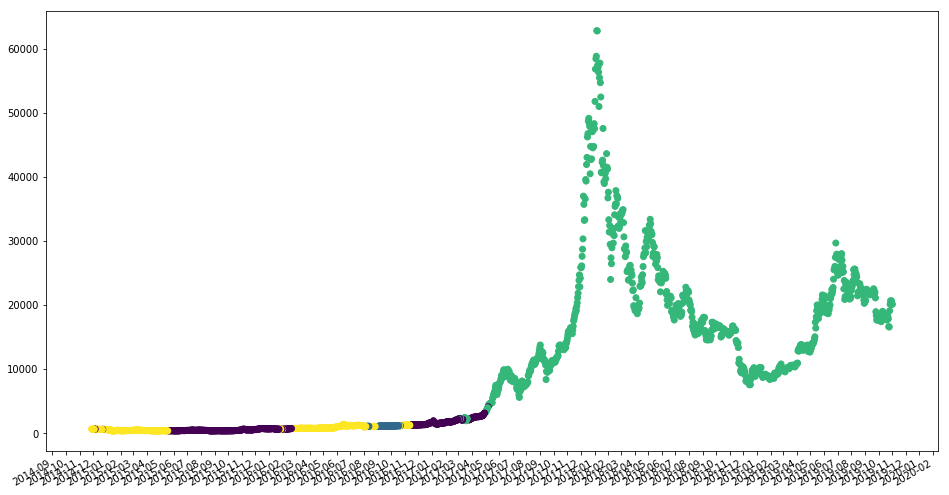

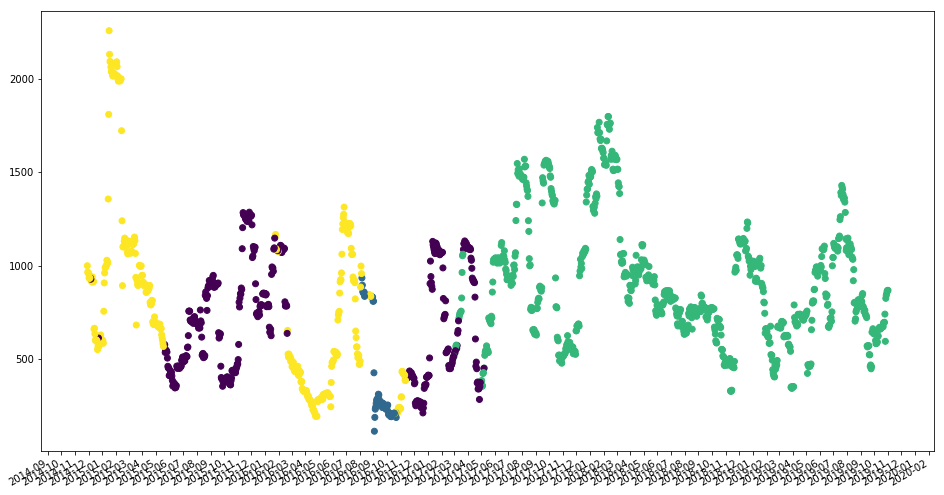

In [92]:
import matplotlib.pyplot as plt
#matplotlib.use('TkAgg')
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib import rc

# read data
df = cvc
df = df.iloc[::-1]
df.index = pd.to_datetime(df.date, yearfirst=True)

#year = mdates.YearLocator()
month = mdates.MonthLocator()

fig, ax = plt.subplots(figsize = (16,9))
ax.scatter(df.index, df.price.values, c=clusters_c)
xfmt = mdates.DateFormatter("%Y-%m")
ax.xaxis.set_major_locator(month)
ax.xaxis.set_major_formatter(xfmt)
fig.autofmt_xdate()
plt.savefig('price0.1.png',transparent=True)

fig, ax = plt.subplots(figsize = (16,9))
ax.scatter(df.index, df.vcrix.values, c=clusters_c)
xfmt = mdates.DateFormatter("%Y-%m")
ax.xaxis.set_major_locator(month)
ax.xaxis.set_major_formatter(xfmt)
fig.autofmt_xdate()
plt.savefig('2vcrix0.1.png',transparent=True)

#plt.rcParams['figure.figsize'] = (16, 9)
#plt.scatter(df.iloc[:,1], df.iloc[:,2], c= clusters_c1)
#plt.scatter(C_c1[:,0], C_c1[:,1],marker='*', s=200, c='#050505')
#plt.savefig('two0.6.png',transparent=True)

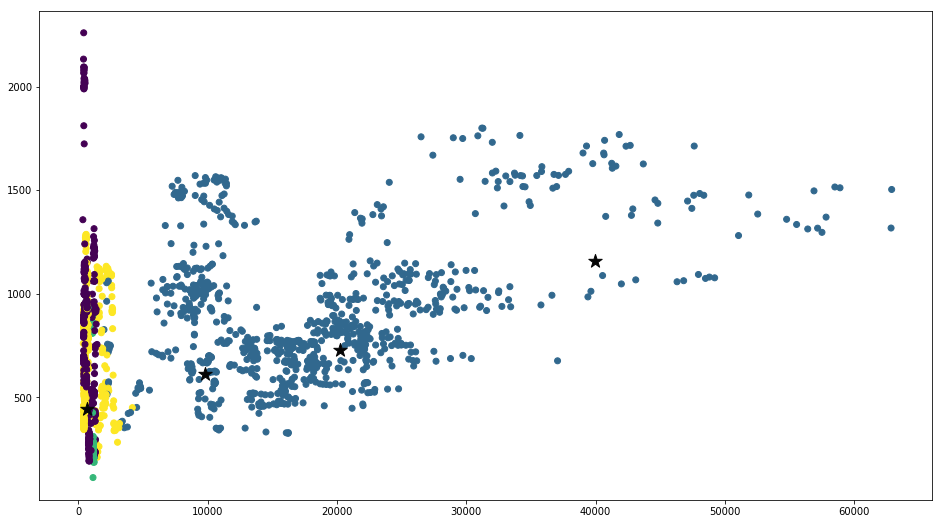

In [91]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.scatter(df.iloc[:,1], df.iloc[:,2], c= clusters_c1)
plt.scatter(C_c1[:,0], C_c1[:,1],marker='*', s=200, c='#050505')

In [157]:

# Define K expectile clustering 
def k_expectile(X, k, tau): 
    X = np.array(X)
#set seeds
    #np.random.seed(456)
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    C = kmeans.cluster_centers_
# X coordinates of random centroids
    #C_x = np.random.uniform(np.min(X[:,0]), np.max(X[:,0]), size=k)
# Y coordinates of random centroids
    #C_y = np.random.uniform(np.min(X[:,1]), np.max(X[:,1]), size=k)

    #C = np.array(list(zip(C_x, C_y)), dtype=np.float32)
    print(C)


# To store the value of centroids when it updates
    C_old = np.zeros(C.shape)
# Cluster Lables(0, 1, 2)
    clusters = np.zeros(len(X))
# Error func. - Distance between new centroids and old centroids
    error = dist(C, C_old)
# Loop will run till the error becomes zero
    while error != 0:
    # Assigning each value to its closest cluster
        for i in range(len(X)):
            for j in range (len(C[0])):
                distances = dist_fun(X[i], C, tau)
                cluster = np.argmin(distances)
                clusters[i] = cluster
    # Storing the old centroid values
        C_old = copy.deepcopy(C)
    # Finding the new centroids by taking the average value
        for d in range(k):
            points = [X[j] for j in range(len(X)) if clusters[j] == d]
            points = np.array(points)
            C[d] = expectile_fun(points,tau)
        error = dist(C, C_old)
    return C, clusters

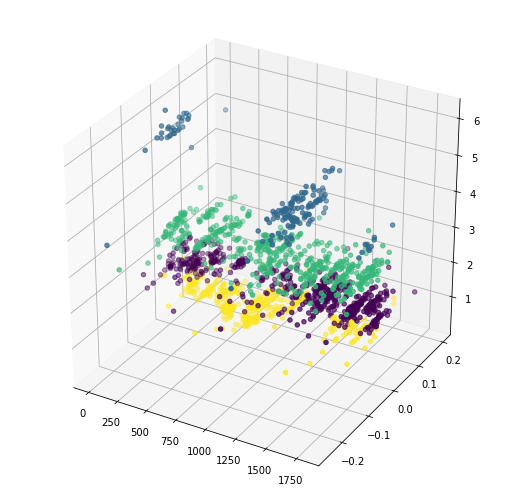

In [138]:
num = tuple(range(len(crc_X)))
X = np.array(crc_X)
y = clusters_c
fig = plt.figure()
ax = plt.axes(projection='3d')

# plot empirical quantiles along with clusters
ax.scatter3D(num, X[:,0], X[:,1], c=y)
#ax.scatter3D(C_c[:, 0], C_c[:, 1],marker='*', s=200, c='#050505')
#plt.savefig('all0.1.png',transparent=True)

In [1]:
plt.rcParams['figure.figsize'] = (9, 9)
plt.scatter(df.index, df.log_ret.value, c= clusters_c)
#plt.scatter(C_c[:,0], C_c[:,1],marker='*', s=200, c='#050505')
#plt.savefig('two0.2.png',transparent=True)

NameError: name 'plt' is not defined

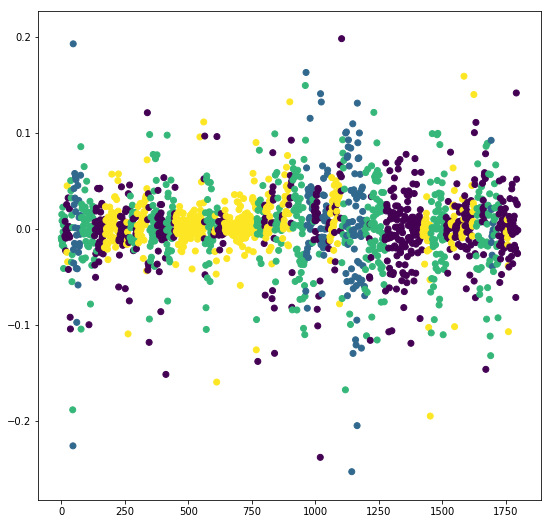

In [141]:
plt.scatter(num, X[:,0], c=y)
#plt.savefig('crix0.3.png',transparent=True)

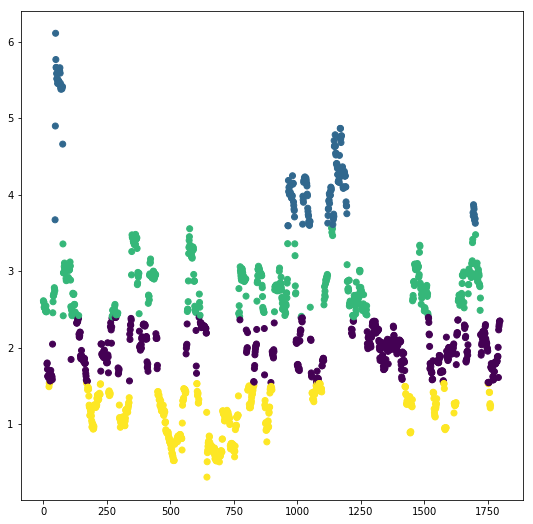

In [135]:
plt.scatter(num, X[:,1], c=y)
#plt.savefig('vcrix0.9.png',transparent=True)

In [365]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('rainbow')
new_cmap_lower = truncate_colormap(cmap, 0, 0.5)
new_cmap_upper = truncate_colormap(cmap, 0.5, 1)


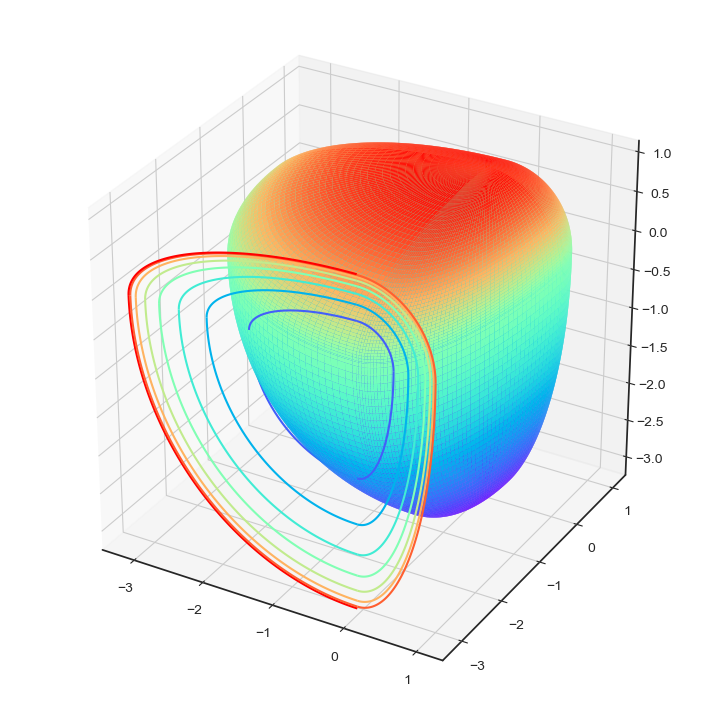

In [389]:
plt.rcParams['figure.figsize'] = (9, 9)
plt.style.use('seaborn-white')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Make data
a,b,c= 0.9, 0.9, 0.9 # Coefficients in a x**2 + b y**2 + c z**2 = 1


u1 = np.linspace(0, 1/2 * np.pi, 100)
u2 = np.linspace(1/2 * np.pi, np.pi, 100)
u3 = np.linspace(np.pi, 3/2 *np.pi, 100)
u4 = np.linspace(3/2 *np.pi, 2 *np.pi, 100)
u  = np.linspace(0, 2* np.pi, 100)
v1 = np.linspace(0, 1/2* np.pi, 100)
v2 = np.linspace(np.pi, 3/2*np.pi, 100)

x1 =  a **(-1/2) * np.outer(np.cos(u1), np.sin(v1))
x2 =  (1-a)**(-1/2) * np.outer(np.cos(u2), np.sin(v1))
x3 =  (1-a)**(-1/2) * np.outer(np.cos(u3), np.sin(v1))
x4 =  a **(-1/2) * np.outer(np.cos(u4), np.sin(v1))

y1 =  b **(-1/2) * np.outer(np.sin(u1), np.sin(v1))
y2 =  b **(-1/2) * np.outer(np.sin(u2), np.sin(v1))
y3 = (1-b)**(-1/2) * np.outer(np.sin(u3), np.sin(v1))
y4 = (1-b)**(-1/2) * np.outer(np.sin(u4), np.sin(v1))

z1 = c**(-1/2) * np.outer(np.ones(np.size(u1)), np.cos(v1))
z2 = (1-c)**(-1/2) * np.outer(np.ones(np.size(u3)), np.cos(v2))


# Plot the surface
ax.plot_surface(x1, y1, z1, color='b',cmap=new_cmap_upper)
ax.plot_surface(x2, y2, z1, color='b',cmap=new_cmap_upper)
ax.plot_surface(x3, y3, z1, color='b',cmap=new_cmap_upper)
ax.plot_surface(x4, y4, z1, color='b',cmap=new_cmap_upper)
ax.plot_surface(x1, y1, z2, color='b',cmap=new_cmap_lower)
ax.plot_surface(x2, y2, z2, color='b',cmap=new_cmap_lower)
ax.plot_surface(x3, y3, z2, color='b',cmap=new_cmap_lower)
ax.plot_surface(x4, y4, z2, color='b',cmap=new_cmap_lower)


#contour lines
ax.contour(x3, y3, z1, zdir='y', offset= -np.pi, cmap='rainbow')
ax.contour(x4, y4, z1, zdir='y', offset= -np.pi, cmap='rainbow')
ax.contour(x3, y3, z2, zdir='y', offset= -np.pi, cmap='rainbow')
ax.contour(x4, y4, z2, zdir='y', offset= -np.pi, cmap='rainbow')
#ax.set_xlim3d(-np.pi, 2*np.pi);
#ax.set_ylim3d(0, 3*np.pi);
#ax.set_zlim3d(-np.pi, 2*np.pi);
plt.savefig('cluster shape0.9.png',transparent=True)


In [27]:
cov = [[1, 0], [0, 1]]
taus = [0.9, 0.9]
X = np.random.multivariate_normal([0, 0], cov, 1000)
expectile_fun(X, taus)

array([0.84431752, 0.8054318 ])

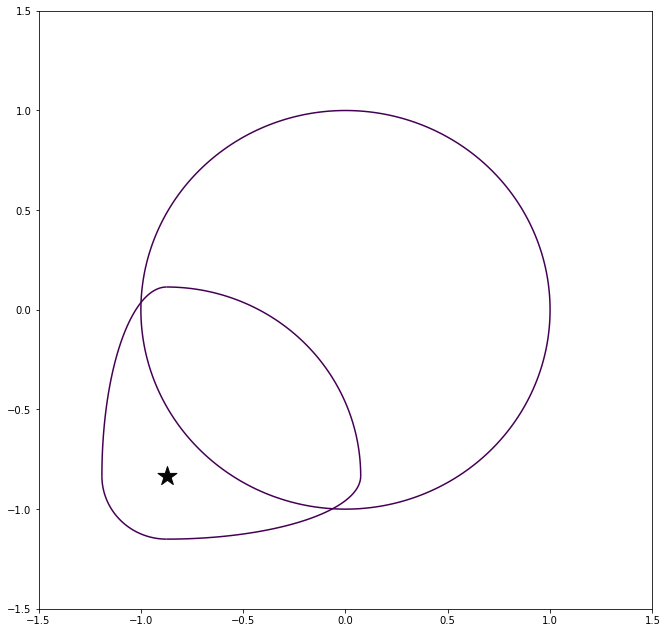

In [28]:
plt.rcParams['figure.figsize'] = (11, 11)

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x,y)
F = X**2 + (Y)**2 - 1



c1,c2 = -0.8742876 , -0.83422153
u1 = np.linspace(0, 1, 100)+c1
u2 = np.linspace(-1, 0, 100)+c1

v1 = np.linspace(0, 1, 100)+c2
v2 = np.linspace(-1, 0, 100)+c2


a,b = 0.9,0.9


X1,Y1 = np.meshgrid(u1,v1)
X2,Y2 = np.meshgrid(u2,v1)
X3,Y3 = np.meshgrid(u2,v2)
X4,Y4 = np.meshgrid(u1,v2)

F1 = (a **(-1/2) * (X1-c1))**2 + (b **(-1/2) *(Y1-c2))**2 - 1
F2 = ((1-a) **(-1/2) * (X2-c1))**2 + (b **(-1/2) *(Y2-c2))**2 - 1
F3 = ((1-a) **(-1/2) * (X3-c1))**2 + ((1-b) **(-1/2) *(Y3-c2))**2 - 1
F4 = (a **(-1/2) * (X4-c1))**2 + ((1-b) **(-1/2) *(Y4-c2))**2 - 1
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.contour(X,Y,F,[0])
plt.contour(X1,Y1,F1,[0])
plt.contour(X2,Y2,F2,[0])
plt.contour(X3,Y3,F3,[0])
plt.contour(X4,Y4,F4,[0])
plt.scatter(c1, c2,marker='*', s=400, c='#050505')
plt.savefig('n01_0.9,0.9.png',transparent=True)
